# Data exploration

Visual exploration of the input data.

In [16]:
import uproot
import numpy as np
import awkward as ak

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from reco.plotting import get_event_window
from reco.distance import get_z_map

ds_name = "CloseByGamma200PUFull"
file_name = "new_ntuples_15410634_194.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

file_path = f"{raw_dir}/{file_name}"
tracksters = uproot.open({file_path: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_path: "ticlNtuplizer/associations"})
clusters = uproot.open({file_path: "ticlNtuplizer/clusters"})


z_map = get_z_map(data_root)

ev_per_file = len(tracksters["raw_em_energy"].array())
print("Events per file:", ev_per_file)

Events per file: 10


In [17]:
hist = uproot.open({file_path: "ticlNtuplizer"})
hist.keys()
# trackstersMerged = uproot.open({file_path: "ticlNtuplizer/trackstersMerged"})

['tracksters;1',
 'clusters;1',
 'graph;1',
 'candidates;1',
 'trackstersMerged;1',
 'associations;1',
 'simtrackstersSC;1',
 'simtrackstersCP;1',
 'tracks;1']

In [18]:
print("NTracksters:", tracksters["NTracksters"].array())
print("NSimTracksters:", simtracksters["stsSC_NTracksters"].array())

NTracksters: [3138, 3060, 3533, 3767, 3083, 3180, 2803, 2775, 3250, 3264]
NSimTracksters: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [31]:
clusters = uproot.open({file_path: "ticlNtuplizer/clusters"})
clusters_x = clusters["position_x"].array()
clusters_y = clusters["position_y"].array()
clusters_z = clusters["position_z"].array()
clusters_e = clusters["energy"].array()

In [32]:
eid = 0

vi = tracksters["vertices_indexes"].array()[eid]
# vi = simtracksters["stsSC_vertices_indexes"].array()[0:eid]

# only take one endcap
vz = ak.Array([clusters_z[eid][indices] for indices in vi])
# tdx = vz > 0

vx = ak.Array([clusters_x[eid][indices] for indices in vi])
vy = ak.Array([clusters_y[eid][indices] for indices in vi])
ve = ak.Array([clusters_e[eid][indices] for indices in vi])

vzm = vz
# vzm = [apply_map(trk, z_map) for trk in vz]

xlim, ylim, zlim = get_event_window(vx, vy, vzm, ve)

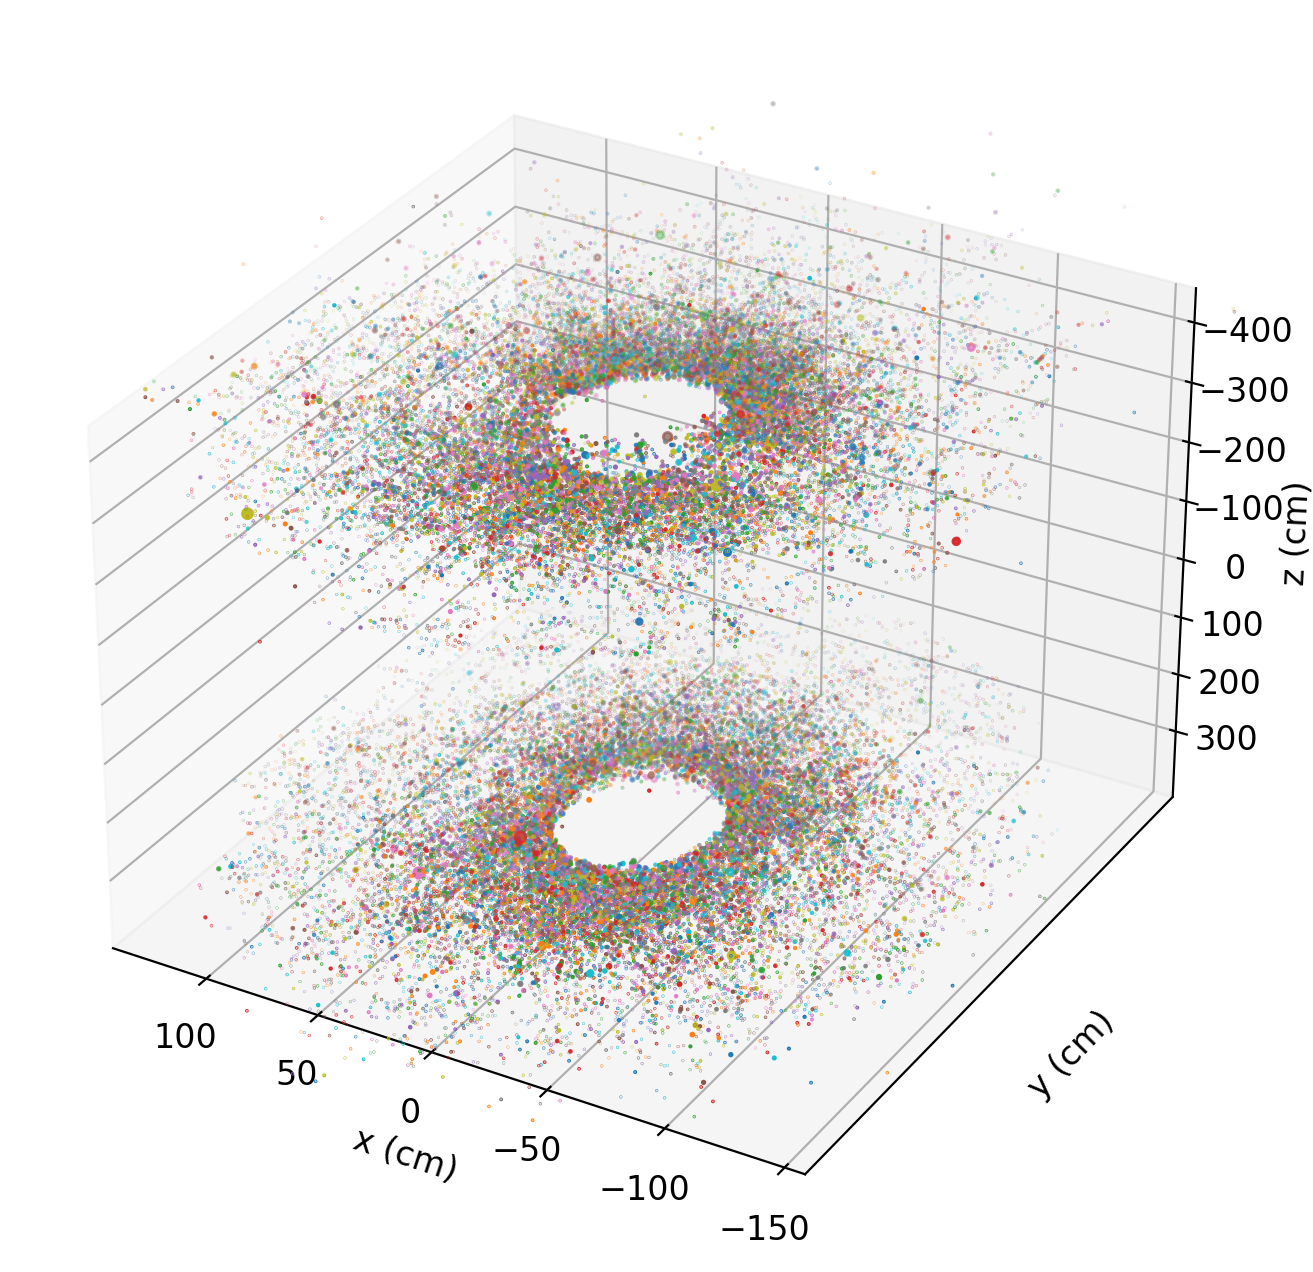

In [33]:
fig = plt.figure(figsize=(8, 8))
# sns.set(style="whitegrid")

ax1 = fig.add_subplot(111, projection='3d')
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_zlim(zlim)
ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
# ax1.set_zlabel("detector layer")
ax1.set_zlabel("z (cm)")
# plt.axis('off')

for x, y, z, e in zip(vx, vy, vzm, ve):
    ax1.scatter(x, y, z, s=e)

# ax1.set_title(f"Front view: reconstruction layer-clusters ({len(vx)})")
# ax1.view_init(0, 180, "x")

ax1.get_yaxis().set_ticks([])
ax1.get_yaxis().set_visible(False)

# Interpretation

I got a single particle and a lot of mess in the reco data.

I only care about the reconstruction quality of this single particle.

How do I know which particle is interesting to me?

I only care about the neighbourhood of this particular trackster?

I could do "min-max" on x,y,z coordinates of the sim-trackster and construct a prism / cone / frustum of all reco-tracksters with a barycentre inside of it.

Let's have a look at an usual profile of a pion.

In [22]:
x_dev = []
y_dev = []
z_dev = []
cle_e = []

# collect averages from 100 tracksters

for fid in range(10):
    fname = f"new_ntuples_15410634_19{fid}.root"
    file_path = f"{raw_dir}/{fname}"
    
    clusters = uproot.open({file_path: "ticlNtuplizer/clusters"})
    simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})

    for eid in range(10):
        clusters_x = clusters["position_x"].array()[eid]
        clusters_y = clusters["position_y"].array()[eid]
        clusters_z = clusters["position_z"].array()[eid]
        clusters_e = clusters["energy"].array()[eid]
        svi = simtracksters["stsSC_vertices_indexes"].array()[eid]
        
        svx = ak.Array([clusters_x[indices] for indices in svi])
        svy = ak.Array([clusters_y[indices] for indices in svi])
        svz = ak.Array([clusters_z[indices] for indices in svi])
        sve = ak.Array([clusters_e[indices] for indices in svi])
        
        tid = 0 # single trackster
        xm = np.mean(svx[tid])
        ym = np.mean(svy[tid])
        zm = np.mean(svz[tid])
        x_dev += [x-xm for x in svx[tid]]
        y_dev += [x-ym for x in svy[tid]]
        z_dev += [x-zm for x in svz[tid]]
        cle_e += [x for x in sve[tid]]

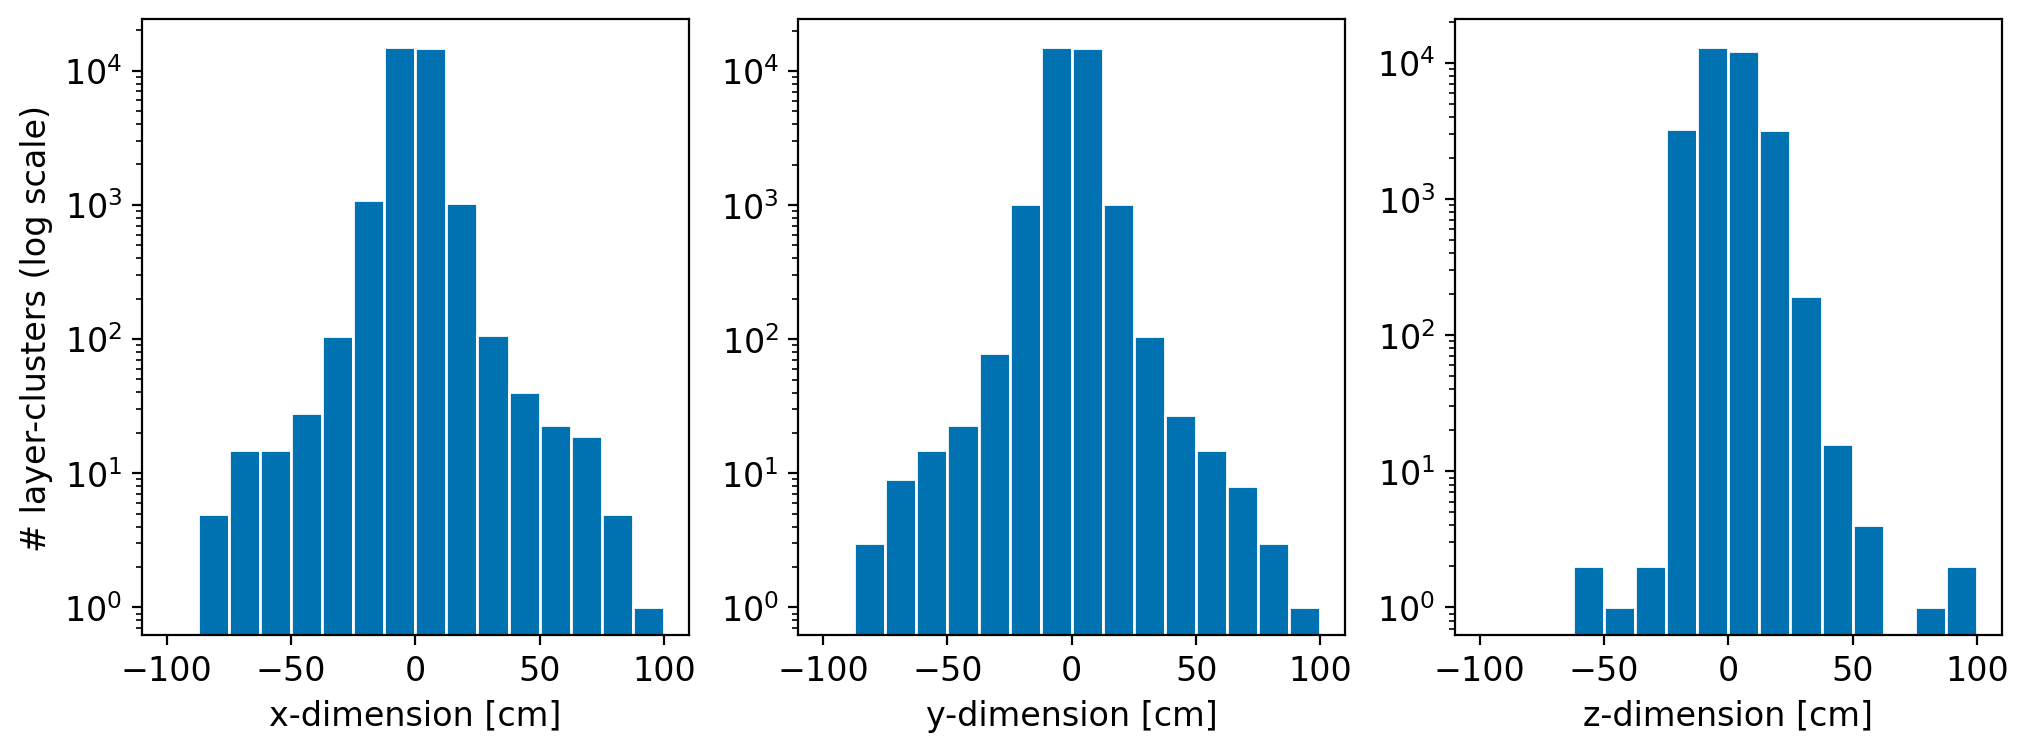

In [23]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.set_ylabel("# layer-clusters (log scale)")

ax1.set_xlabel("x-dimension [cm]")
ax1.set_yscale("log")
ax1.hist(x_dev, edgecolor="white", color="#0072B2", range=(-100, 100), bins=16)

ax2.set_xlabel("y-dimension [cm]")
ax2.set_yscale("log")
ax2.hist(y_dev, edgecolor="white", color="#0072B2", range=(-100, 100), bins=16)

ax3.set_yscale("log")
ax3.set_xlabel("z-dimension [cm]")
ax3.hist(z_dev, edgecolor="white", color="#0072B2", range=(-100, 100), bins=16)

# fig.savefig('export/photon-distribution.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

## Compute average X and Y per layer

In [24]:
eid = 0
clusters_x = clusters["position_x"].array()[eid]
clusters_y = clusters["position_y"].array()[eid]
clusters_z = clusters["position_z"].array()[eid]
clusters_e = clusters["energy"].array()[eid]

svi = simtracksters["stsSC_vertices_indexes"].array()[eid]
svz = ak.Array([clusters_z[indices] for indices in svi])
svx = ak.Array([clusters_x[indices] for indices in svi])
svy = ak.Array([clusters_y[indices] for indices in svi])
sve = ak.Array([clusters_e[indices] for indices in svi])

In [25]:
all_z = list(sorted(set(svz[tid])))

x_coords = {z: [] for z in all_z}
y_coords = {z: [] for z in all_z}
layer_e = {z: [] for z in all_z}

In [26]:
for x, y, z, e in zip(svx[tid], svy[tid], svz[tid], sve[tid]):
    x_coords[z].append(x)   
    y_coords[z].append(y)
    layer_e[z].append(e)

In [27]:
x_avg = []
y_avg = []
e_sum = []

for z in all_z:
    x_avg.append(np.mean(x_coords[z]))  # should weight by energy and multiplicity here
    y_avg.append(np.mean(y_coords[z]))  # should weight by energy and multiplicity here
    e_sum.append(np.sum(layer_e[z]))

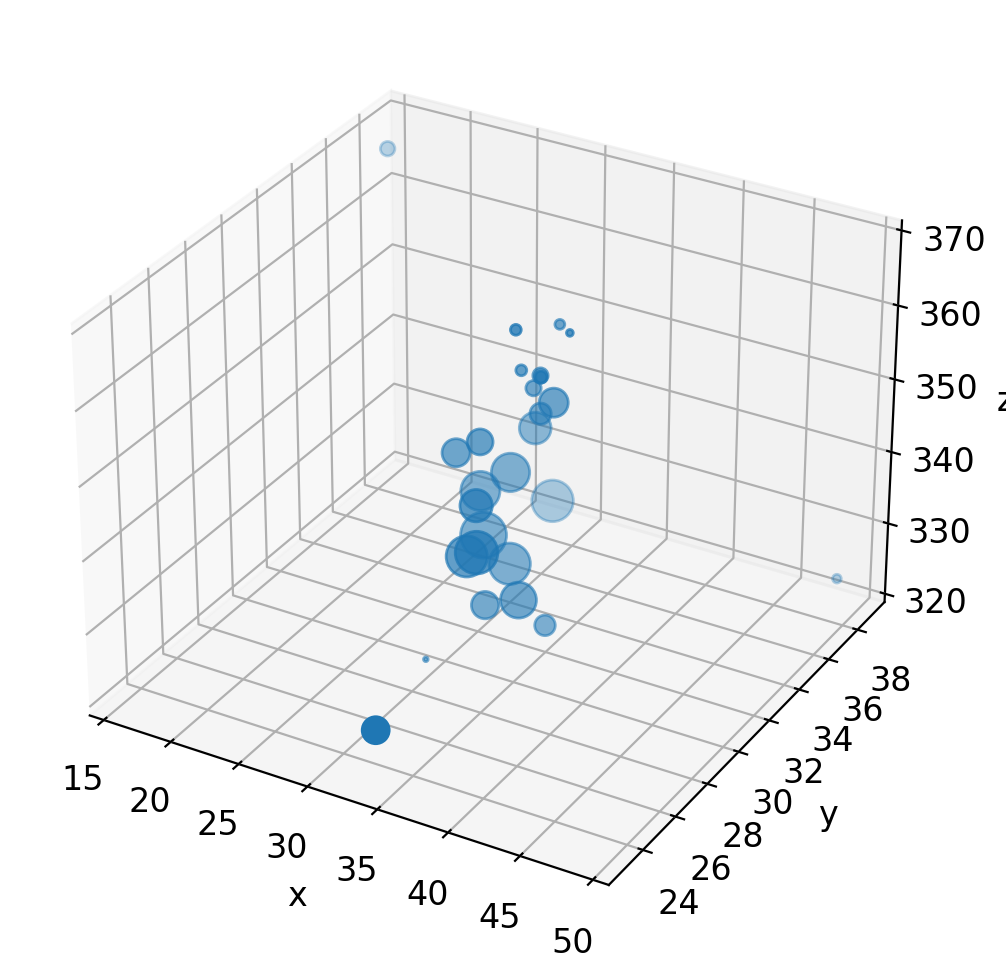

In [28]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_avg, y_avg, all_z, s=np.array(e_sum)*10)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# ax.view_init(45, 45, "x")
plt.show()

Plot deviation from the layer mean

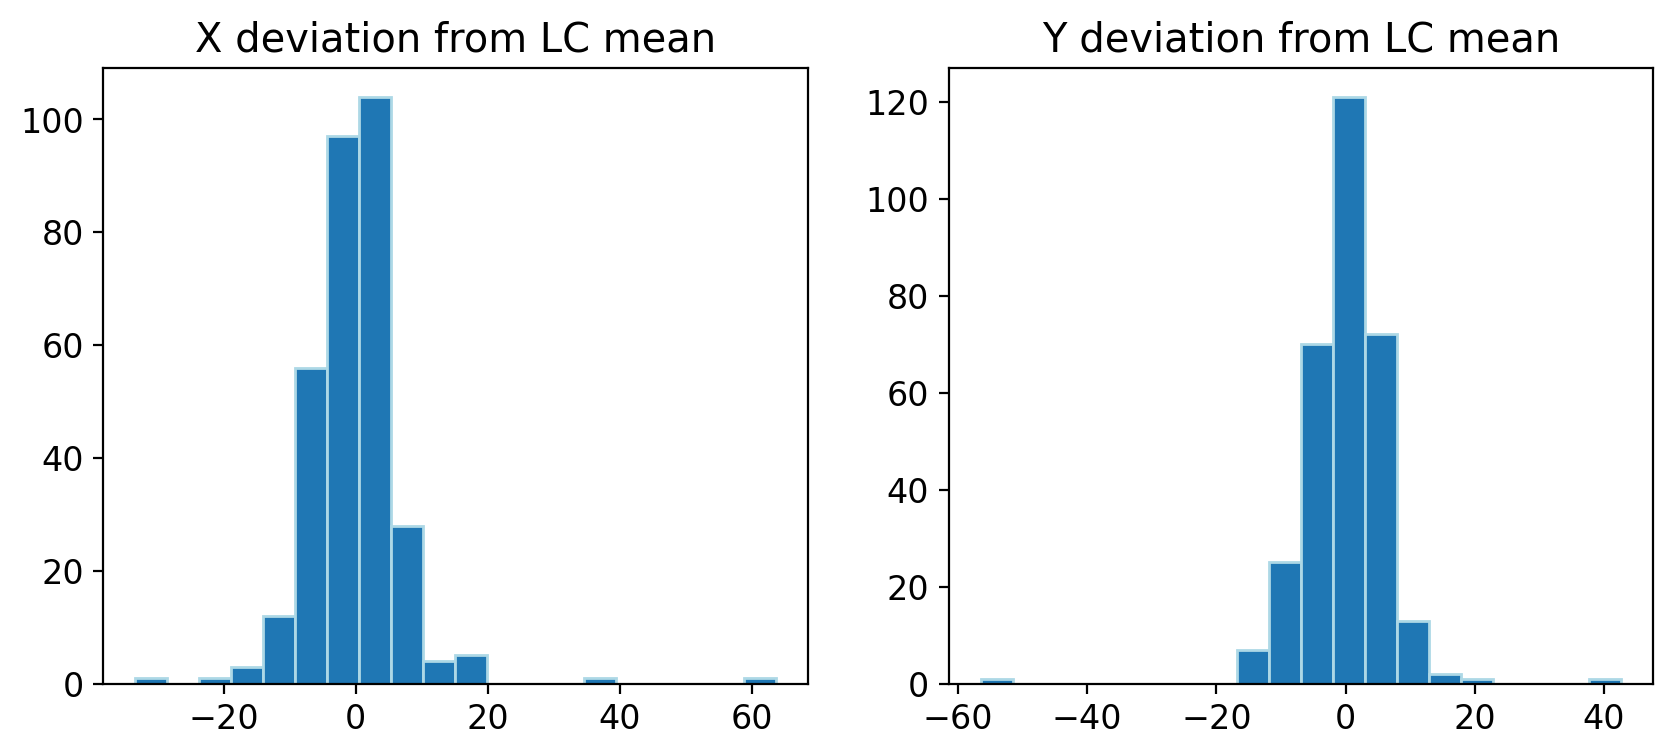

In [29]:
x_dev = []
y_dev = []

for i, z in enumerate(all_z):
    xm = x_avg[i]
    ym = y_avg[i]
    x_dev += [xm - x for x in x_coords[z]]
    y_dev += [ym - y for y in y_coords[z]]

fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title("X deviation from LC mean")
ax1.hist(x_dev, bins=20, edgecolor="lightblue")

ax2.set_title("Y deviation from LC mean")
ax2.hist(y_dev, bins=20, edgecolor="lightblue")

plt.show()
